In [1]:
# IMPORTS
import os
import numpy as np
from utils.data import read_stock_history, normalize
import matplotlib.pyplot as plt
#import matplotlib
import pandas as pd
#import seaborn as sns
import tensorflow as tf
from model.ddpg.actor import ActorNetwork
from model.ddpg.critic import CriticNetwork
from model.ddpg.ddpg import DDPG
from model.ornstein_uhlenbeck import OrnsteinUhlenbeckActionNoise
from model.td3.actor import TD3ActorNetwork
from model.td3.critic import TD3CriticNetwork
from model.td3.td3 import TD3
from stock_trading import StockActor, StockCritic, TD3StockActor, TD3StockCritic, obs_normalizer, get_model_path, get_result_path, test_model, get_variable_scope, test_model_multiple
from environment.portfolio import PortfolioEnv, MultiActionPortfolioEnv, max_drawdown, sharpe, sortino, create_close_dataframe, convert_prices
import numpy as np
import tflearn
from stock_trading import test_portfolio_selection, test_portfolio_selection_multiple, plot_weights, plot_portfolio_values, results_table, results_table_row, returns_from_cumulative, extract_from_infos, returns_from_cumulative
from ensemble_strategy import ensemble_test
from technical_indicators.technical_indicators import full_rmr_moving_average, olmar_moving_average
import json

tf.__version__
print("Imports Complete")







Imports Complete


In [2]:
# Models [Framework, Window, Technical Indicators]
model_dict = [
    {
        'framework': 'TD3', 
        'window': 3, 
        'technical_indicators_flag': True
    }, 
    {
        'framework': 'TD3', 
        'window': 7, 
        'technical_indicators_flag': True
    }, 
    {
        'framework': 'TD3', 
        'window': 11, 
        'technical_indicators_flag': True
    }, 
    {
        'framework': 'TD3', 
        'window': 14, 
        'technical_indicators_flag': True
    }
]

In [3]:
# common settings
batch_size = 64
action_bound = 1.
tau = 1e-3

model_names = []
predictor_type = 'lstm'
use_batch_norm = True
log_return = True
load_technical_indicators = True
maximum_window = max([model['window'] for model in model_dict])
dates = []

In [4]:
# Open Config
config_file_path = 'config/stock.json'   
with open(config_file_path) as f:
    config = json.load(f)
assert config != None, "Can't load config file"

actor_learning_rate = config['actor learning rate']
critic_learning_rate = config['critic learning rate']

In [5]:
# Stock History
dataset_name = 'SP500'
history, assets, date_list = read_stock_history(filepath='utils/datasets/{}.h5'.format(dataset_name))
history = history[:, :, :4]
nb_classes = len(history) + 1
print("Dataset: {}".format(dataset_name))
print("Assets: {}".format(assets))
print("Stock History Shape: {}".format(history.shape))
print("Full Stock History Date Range: {} -> {}".format(date_list[0], date_list[-1]))

Dataset: SP500
Assets: ['AAPL', 'MSFT', 'JNJ', 'JPM', 'PG', 'UNH', 'HD', 'DIS', 'VZ', 'CMCSA', 'ADBE', 'PFE', 'BAC', 'INTC', 'T', 'WMT', 'MRK', 'KO', 'PEP', 'ABT', 'TMO', 'CSCO', 'CVX', 'NKE', 'XOM']
Stock History Shape: (25, 6483, 4)
Full Stock History Date Range: 03/01/1995 -> 30/09/2020


In [6]:
# Training/Testing Date Range
if dataset_name == 'Hegde':
    full_length = len(date_list)
    train_ratio = 7/10
    validation_ratio = 2/10
    train_start_date = date_list[maximum_window]
    train_end_date = date_list[(int)(full_length * train_ratio) - 1]
    #validation_start_date = date_list[(int)(full_length * train_ratio)]
    #validation_end_date = date_list[(int)(full_length * (train_ratio + validation_ratio)) - 1]
    test_start_date = date_list[(int)(full_length * (train_ratio + validation_ratio))]
    test_end_date = date_list[full_length - 2]
else:
    full_length = len(date_list)
    train_test_ratio = 6/7
    train_start_date = date_list[maximum_window]
    train_end_date = date_list[(int)(full_length * train_test_ratio)-1]
    test_start_date = date_list[(int)(full_length * train_test_ratio)]
    test_end_date = date_list[full_length-2]
print("Training Date Range: {} -> {} ({} Steps)".format(train_start_date, train_end_date, 
                                                    (int)(date_list.index(train_end_date) - date_list.index(train_start_date))))
print("Testing Date Range: {} -> {} ({} Steps)".format(test_start_date, test_end_date, 
                                                    (int)(date_list.index(test_end_date) - date_list.index(test_start_date))))

Training Date Range: 23/01/1995 -> 25/01/2017 (5541 Steps)
Testing Date Range: 26/01/2017 -> 29/09/2020 (925 Steps)


In [7]:
# Generate Technical Indicators
def GenerateTechnicalIndicators(window_length, debug = False):
    if debug:
        print('history.shape: {}'.format(history.shape))

    # Check if just close is fed or full dataset
    if history.shape[2] == 4:
        # Get Close
        history_close = history[:, :, 3]
    elif history.shape[2] == 2:
        # Assume the one sent is the close price
        history_close = history[:, :, 1]

    if debug:
        print('history_close.shape: {}'.format(history_close.shape))

    # Add Technical Indicators to be included in state
    #if technical_indicators_flag:
    technical_indicator_history = []

    # Close Price DataFrame for on-line Portfolio Selection
    temp_close_df = create_close_dataframe(history, assets, date_list)
    temp_close_df = convert_prices(temp_close_df, 'raw', True)    
    if debug:
        print('temp_close_df.shape: {}'.format(temp_close_df.shape))

    rmr_moving_average_df = full_rmr_moving_average(temp_close_df, window_length)
    for i in range(len(assets)):
        # Create List
        ti = []
        #ti.append([olmar_moving_average(temp_close_df[assets[i]], window_length)]) # Based on OLMAR
        ti.append([rmr_moving_average_df[assets[i]]]) # Based on RMR

        # Turn to Array
        ti = np.vstack(ti)

        ti_reshaped = []
        for j in range(temp_close_df.shape[0]):
            ti_reshaped.append(ti[:, j])   

        technical_indicator_history.append(ti_reshaped)

    technical_indicator_history = np.array(technical_indicator_history)    
    if debug:
        print('technical_indicators.shape: {}'.format(technical_indicator_history.shape)) 
    #else:
    #    technical_indicator_history = None
        
    return technical_indicator_history

In [8]:
if load_technical_indicators:
    # Load Technical Indicators dataset
    ti_dict = np.load('technical_indicators/dictionaries/ti_dict-{}-rmr.npy'.format(dataset_name),allow_pickle='TRUE').item()
else:
    ti_dict = {}
    distinct_window_lengths = []
    for m in model_dict:
        if m['window'] not in distinct_window_lengths:
            distinct_window_lengths.append(m['window'])
            technical_indicator_history = GenerateTechnicalIndicators(m['window'])
            ti_dict[m['window']] = technical_indicator_history
    np.save('technical_indicators/dictionaries/ti_dict-{}-rmr.npy'.format(dataset_name), ti_dict) 

In [9]:
# instantiate environment
for m in model_dict:
    framework = m['framework']
    window_length = m['window']
    technical_indicators_flag = m['technical_indicators_flag']
        
    # Add name
    if technical_indicators_flag:
        name = '{}_{}_window_{}_predictor_{}_rmr-pred'.format(dataset_name, framework, window_length, predictor_type)
    else:
        name = '{}_{}_window_{}_predictor_{}'.format(dataset_name, framework, window_length, predictor_type)
    m['name'] = name
    model_names.append(name)
    
    tf.reset_default_graph()
    sess = tf.Session()
    tflearn.config.init_training_mode()
    action_dim = [nb_classes]
    
    if technical_indicators_flag:
        technical_indicator_history = ti_dict[window_length]
        state_dim = [nb_classes, window_length+technical_indicator_history.shape[2]]
    else:
        state_dim = [nb_classes, window_length]

    variable_scope = get_variable_scope(dataset_name, framework, window_length, predictor_type, 
                                        use_batch_norm, technical_indicators_flag)

    with tf.variable_scope(variable_scope):

        if(framework == 'DDPG'):
            actor = StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, 
                               predictor_type, use_batch_norm)
            critic = StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                     learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(), 
                     predictor_type=predictor_type, use_batch_norm=use_batch_norm)
            actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

            model_save_path = get_model_path(dataset_name, framework, window_length, predictor_type, use_batch_norm, technical_indicators_flag)
            summary_path = get_result_path(dataset_name, framework, window_length, predictor_type, use_batch_norm, technical_indicators_flag)

            ddpg_model = DDPG(None, sess, actor, critic, actor_noise, obs_normalizer=obs_normalizer,
                              log_return=log_return, config_file='config/stock.json', 
                              model_save_path=model_save_path, summary_path=summary_path)
            ddpg_model.initialize(load_weights=True, verbose=True)
            
            # Add model
            m['model'] = ddpg_model

        elif(framework == 'TD3'):
            actor = TD3StockActor(sess, state_dim, action_dim, action_bound, 1e-4, tau, batch_size, 
                                  predictor_type, use_batch_norm)
            critic = TD3StockCritic(sess=sess, state_dim=state_dim, action_dim=action_dim, tau=1e-3,
                     learning_rate=1e-3, num_actor_vars=actor.get_num_trainable_vars(),
                     predictor_type=predictor_type, use_batch_norm=use_batch_norm,
                       inp_actions=actor.scaled_out)
            actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

            model_save_path = get_model_path(dataset_name, framework, window_length, predictor_type, use_batch_norm, technical_indicators_flag)
            summary_path = get_result_path(dataset_name, framework, window_length, predictor_type, use_batch_norm, technical_indicators_flag)

            td3_model = TD3(None, sess, actor, critic, actor_noise, obs_normalizer=obs_normalizer, 
                            log_return=log_return, config_file='config/stock.json', 
                            model_save_path=model_save_path, summary_path=summary_path)
            td3_model.initialize(load_weights=True, verbose=True)
            
            # Add model
            m['model'] = td3_model


Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.





INFO:tensorflow:Restoring parameters from weights/SP500/TD3/lstm/window_3/batch_norm/technical_indicators/checkpoint.ckpt
Loading is_training:0 from checkpoint. Name: is_training
Loading SP500_TD3_lstm_window_3_batch_norm_technical_indicators/LSTM/SP500_TD3_lstm_window_3_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Matrix:0 from checkpoint. Name: SP500_TD3_lstm_window_3_batch_norm_technical_indicators/LSTM/SP500_TD3_lstm_window_3_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Matrix
Loading SP500_TD3_lstm_window_3_batch_norm_technical_indi

INFO:tensorflow:Restoring parameters from weights/SP500/TD3/lstm/window_7/batch_norm/technical_indicators/checkpoint.ckpt
Loading is_training:0 from checkpoint. Name: is_training
Loading SP500_TD3_lstm_window_7_batch_norm_technical_indicators/LSTM/SP500_TD3_lstm_window_7_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Matrix:0 from checkpoint. Name: SP500_TD3_lstm_window_7_batch_norm_technical_indicators/LSTM/SP500_TD3_lstm_window_7_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Matrix
Loading SP500_TD3_lstm_window_7_batch_norm_technical_indicators/LSTM/SP500_TD3_lstm_window_7_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Bias:0 from checkpoint. Name: SP500_TD3_lstm_window_7_batch_norm_technical_indicators/LSTM/SP500_TD3_lstm_window_7_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Bias
Loading SP500_TD3_lstm_window_7_batch_norm_technical_indicators/FullyConnected/W:0 from checkpoint. Name: SP500_TD3_lstm_window_7_batch_norm_technical_indicato

INFO:tensorflow:Restoring parameters from weights/SP500/TD3/lstm/window_11/batch_norm/technical_indicators/checkpoint.ckpt
Loading is_training:0 from checkpoint. Name: is_training
Loading SP500_TD3_lstm_window_11_batch_norm_technical_indicators/LSTM/SP500_TD3_lstm_window_11_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Matrix:0 from checkpoint. Name: SP500_TD3_lstm_window_11_batch_norm_technical_indicators/LSTM/SP500_TD3_lstm_window_11_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Matrix
Loading SP500_TD3_lstm_window_11_batch_norm_technical_indicators/LSTM/SP500_TD3_lstm_window_11_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Bias:0 from checkpoint. Name: SP500_TD3_lstm_window_11_batch_norm_technical_indicators/LSTM/SP500_TD3_lstm_window_11_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Bias
Loading SP500_TD3_lstm_window_11_batch_norm_technical_indicators/FullyConnected/W:0 from checkpoint. Name: SP500_TD3_lstm_window_11_batch_norm_technic

INFO:tensorflow:Restoring parameters from weights/SP500/TD3/lstm/window_14/batch_norm/technical_indicators/checkpoint.ckpt
Loading is_training:0 from checkpoint. Name: is_training
Loading SP500_TD3_lstm_window_14_batch_norm_technical_indicators/LSTM/SP500_TD3_lstm_window_14_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Matrix:0 from checkpoint. Name: SP500_TD3_lstm_window_14_batch_norm_technical_indicators/LSTM/SP500_TD3_lstm_window_14_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Matrix
Loading SP500_TD3_lstm_window_14_batch_norm_technical_indicators/LSTM/SP500_TD3_lstm_window_14_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Bias:0 from checkpoint. Name: SP500_TD3_lstm_window_14_batch_norm_technical_indicators/LSTM/SP500_TD3_lstm_window_14_batch_norm_technical_indicators/LSTM/BasicLSTMCell/Linear/Bias
Loading SP500_TD3_lstm_window_14_batch_norm_technical_indicators/FullyConnected/W:0 from checkpoint. Name: SP500_TD3_lstm_window_14_batch_norm_technic

-----------------
#### IN SAMPLE

/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


<Figure size 432x288 with 0 Axes>

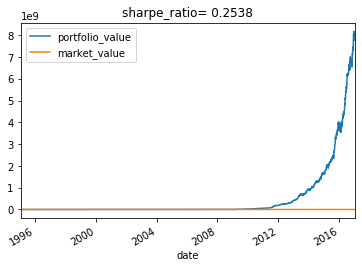

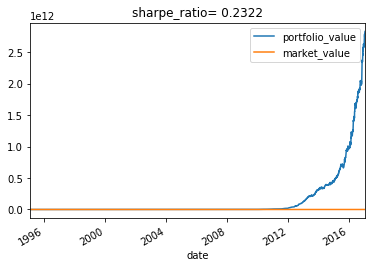

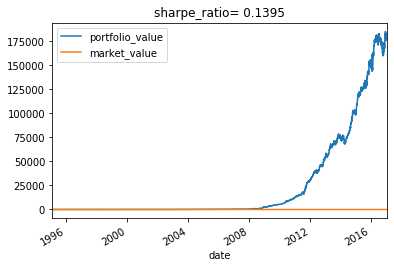

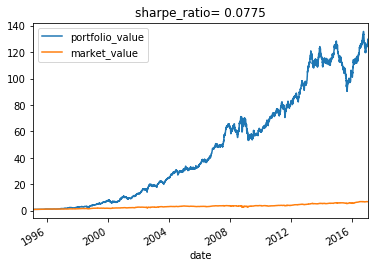

In [10]:
# Compiled Results
for m in model_dict:
    framework = m['framework']
    window_length = m['window']
    technical_indicators_flag = m['technical_indicators_flag']
    name = m['name']
    model = m['model']
    
    if technical_indicators_flag:
        env = PortfolioEnv(history, assets, date_list, start_date=train_start_date, 
                              end_date=train_end_date, window_length=window_length, 
                                  technical_indicators_flag=True, 
                                  technical_indicator_history=ti_dict[window_length])
    else:
        env = PortfolioEnv(history, assets, date_list, start_date=train_start_date, 
                              end_date=train_end_date, window_length=window_length)

    
    dates, observations, _, actions, _, _, portfolio_values, in_market_portfolio_values = test_model(env, model)
    
    m['in_actions'] = actions
    m['in_portfolio_values'] = portfolio_values

#### Plot

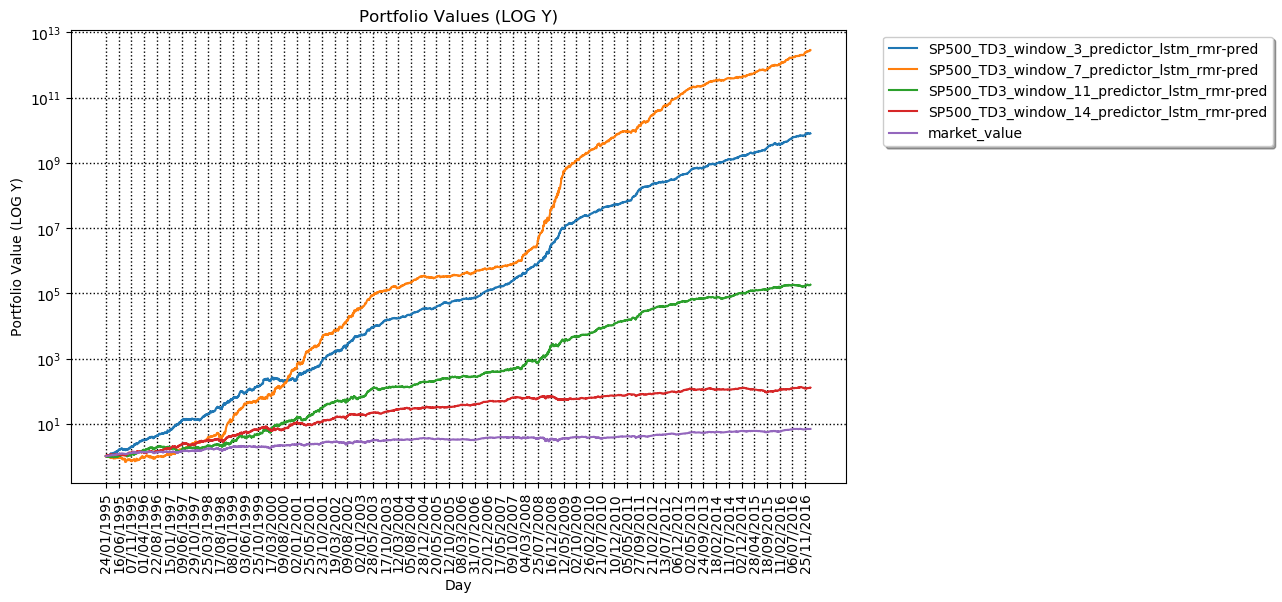

In [11]:
log_y = True
df = pd.DataFrame()
df["Date"] = dates
df.set_index('Date', inplace=True)
plt.figure(figsize=(10, 6), dpi=100)
if log_y:
    plt.title('Portfolio Values (LOG Y)')
    plt.ylabel('Portfolio Value (LOG Y)')
else:
    plt.title('Portfolio Values')
    plt.ylabel('Portfolio Value')
plt.xlabel('Day')
# Models
for m in model_dict:
    df[m['name']] = m['in_portfolio_values']
    plt.plot(df[m['name']], label=m['name'])
# Market
df['market_value'] = in_market_portfolio_values
plt.plot(df['market_value'], label='market_value')
if log_y:
    plt.yscale('log')
plt.xticks(np.arange(0, len(dates), 100))
plt.xticks(rotation=90)
plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1), shadow=True, ncol=1)
plt.grid(color='black', linestyle=':', linewidth=1)
plt.show()

In [12]:
# RESULT
df = pd.DataFrame(columns=['Portfolio', 'Average Daily Yield (%)', 'Sharpe Ratio (%)', 'Sortino Ratio (%)', 'Maximum Drawdown (%)',
                           'Final Portfolio Value'])
for m in model_dict:
    df = results_table_row(df, m['name'],
                           returns_from_cumulative(m['in_portfolio_values']),
                           m['in_portfolio_values'])
# Market
df = results_table_row(df, 'market_value',
                           returns_from_cumulative(in_market_portfolio_values),
                           in_market_portfolio_values)
df

,Portfolio,Average Daily Yield (%),Sharpe Ratio (%),Sortino Ratio (%),Maximum Drawdown (%),Final Portfolio Value
0,SP500_TD3_window_3_predictor_lstm_rmr-pred,0.4256,25.3553,42.6992,27.3259,7.911663e+09
1,SP500_TD3_window_7_predictor_lstm_rmr-pred,0.5453,23.2094,38.8870,34.8444,2.831365e+12
2,SP500_TD3_window_11_predictor_lstm_rmr-pred,0.2323,13.9288,22.4553,34.4001,1.827896e+05
3,SP500_TD3_window_14_predictor_lstm_rmr-pred,0.0949,7.7255,10.8623,29.5539,1.289360e+02
4,market_value,0.0384,4.4983,6.1933,27.5928,6.957000e+00


-----------------
#### OUT OF SAMPLE

/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


<Figure size 432x288 with 0 Axes>

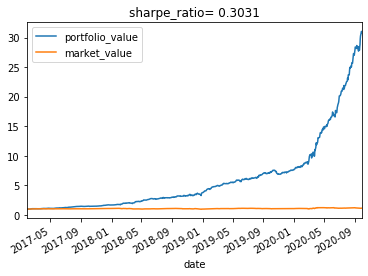

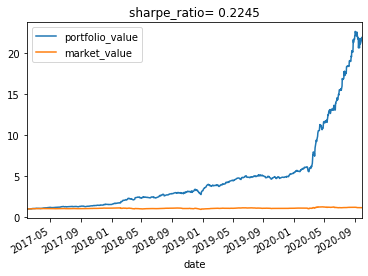

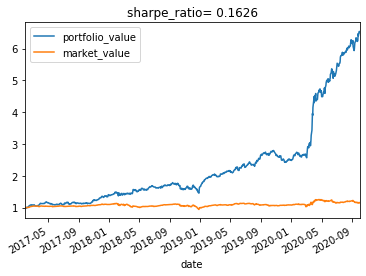

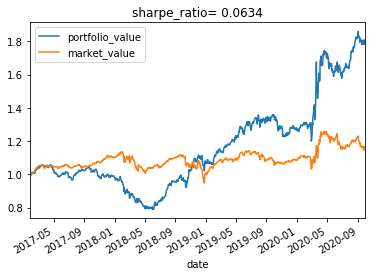

In [13]:
# Compiled Results
for m in model_dict:
    framework = m['framework']
    window_length = m['window']
    technical_indicators_flag = m['technical_indicators_flag']
    name = m['name']
    model = m['model']
    
    if technical_indicators_flag:
        env = PortfolioEnv(history, assets, date_list, start_date=test_start_date, 
                              end_date=test_end_date, window_length=window_length, 
                                  technical_indicators_flag=True, 
                                  technical_indicator_history=ti_dict[window_length])
    else:
        env = PortfolioEnv(history, assets, date_list, start_date=test_start_date, 
                              end_date=test_end_date, window_length=window_length)

    
    dates, observations, _, actions, _, _, portfolio_values, market_portfolio_values = test_model(env, model)
    
    m['actions'] = actions
    m['portfolio_values'] = portfolio_values

#### Plot

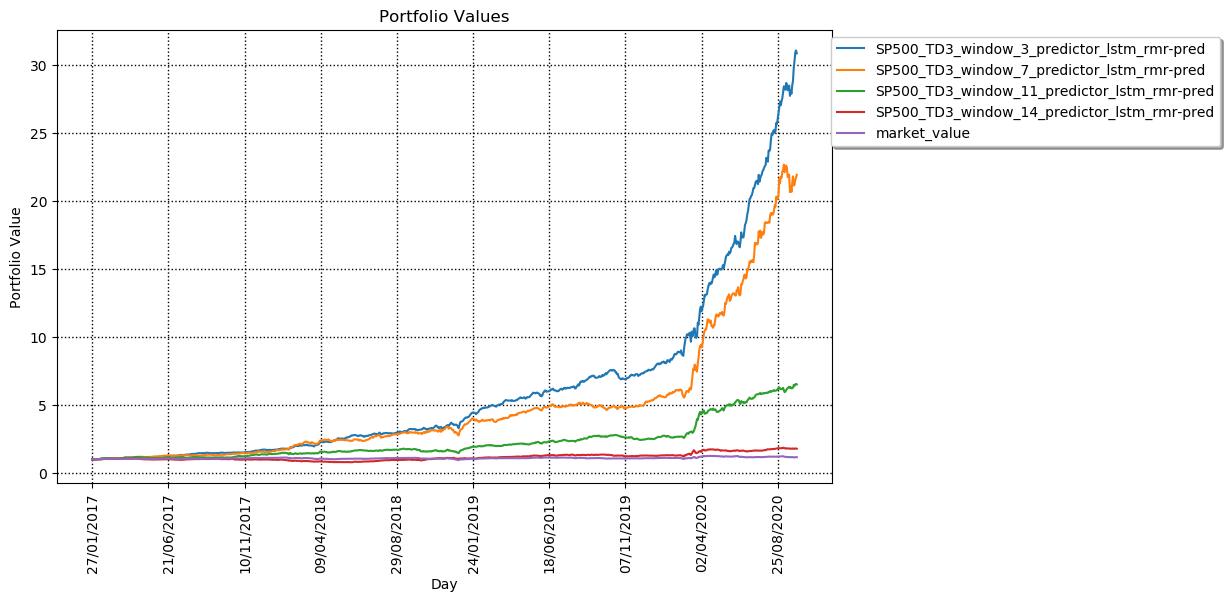

In [14]:
log_y = False
df = pd.DataFrame()
df["Date"] = dates
df.set_index('Date', inplace=True)
plt.figure(figsize=(10, 6), dpi=100)
if log_y:
    plt.title('Portfolio Values (LOG Y)')
    plt.ylabel('Portfolio Value (LOG Y)')
else:
    plt.title('Portfolio Values')
    plt.ylabel('Portfolio Value')
plt.xlabel('Day')
# Models
for m in model_dict:
    df[m['name']] = m['portfolio_values']
    plt.plot(df[m['name']], label=m['name'])
# Market
df['market_value'] = market_portfolio_values
plt.plot(df['market_value'], label='market_value')
if log_y:
    plt.yscale('log')
plt.xticks(np.arange(0, len(dates), 100))
plt.xticks(rotation=90)
plt.legend(loc='upper center', bbox_to_anchor=(1.25, 1), shadow=True, ncol=1)
plt.grid(color='black', linestyle=':', linewidth=1)
plt.show()

In [15]:
# RESULT
df = pd.DataFrame(columns=['Portfolio', 'Average Daily Yield (%)', 'Sharpe Ratio (%)', 'Sortino Ratio (%)', 'Maximum Drawdown (%)',
                           'Final Portfolio Value'])
for m in model_dict:
    df = results_table_row(df, m['name'],
                           returns_from_cumulative(m['portfolio_values']),
                           m['portfolio_values'])
# Market
df = results_table_row(df, 'market_value',
                           returns_from_cumulative(market_portfolio_values),
                           market_portfolio_values)
df

,Portfolio,Average Daily Yield (%),Sharpe Ratio (%),Sortino Ratio (%),Maximum Drawdown (%),Final Portfolio Value
0,SP500_TD3_window_3_predictor_lstm_rmr-pred,0.3789,30.3058,49.2036,10.8484,30.843
1,SP500_TD3_window_7_predictor_lstm_rmr-pred,0.3460,22.4598,35.2077,18.5811,21.913
2,SP500_TD3_window_11_predictor_lstm_rmr-pred,0.2109,16.2456,25.8759,18.5374,6.513
3,SP500_TD3_window_14_predictor_lstm_rmr-pred,0.0691,6.4011,8.7301,25.4936,1.785
4,market_value,0.0183,2.5726,3.1334,16.7101,1.160


#### Compare with online-portfolio selection

In [16]:
# Set Up Environment
env = PortfolioEnv(history, assets, date_list, start_date=test_start_date, 
                              end_date=test_end_date, window_length=3, olps=True)

olps_model_names = ['CRP', 'BCRP', 'OLMAR', 'PAMR', 'RMR', 'WMAMR', 'EG', 'ONS', 'UP']
observations_list, olps_portfolio_values_list, weights_list, dates = test_portfolio_selection_multiple(env, 
                                                                                                olps_model_names)

/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


=========CRP=========
len(weights_array): 6483
=========BCRP=========
252.0
len(weights_array): 926
=========OLMAR=========
len(weights_array): 926
=========PAMR=========
len(weights_array): 926
=========RMR=========
len(weights_array): 926
=========WMAMR=========
len(weights_array): 926
=========EG=========
len(weights_array): 926
=========ONS=========
len(weights_array): 926
=========UP=========
len(weights_array): 926


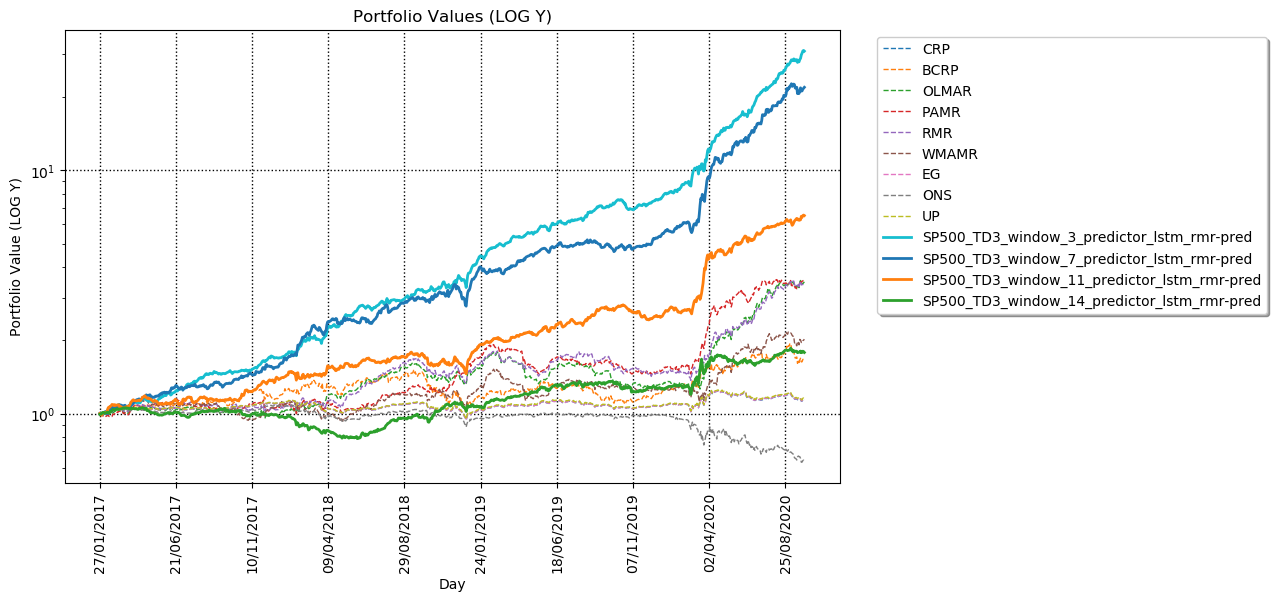

In [17]:
# Plot Together
log_y = True
df = pd.DataFrame()
df["Date"] = dates
df.set_index('Date', inplace=True)
plt.figure(figsize=(10, 6), dpi=100)
if log_y:
    plt.title('Portfolio Values (LOG Y)')
    plt.ylabel('Portfolio Value (LOG Y)')
else:
    plt.title('Portfolio Values')
    plt.ylabel('Portfolio Value')
plt.xlabel('Day')

# OLPS
for i in range(len(olps_model_names)):
    df[olps_model_names[i]] = olps_portfolio_values_list[i]
    plt.plot(df[olps_model_names[i]], label=olps_model_names[i], 
             linewidth=1, 
             linestyle='dashed')

# Our models
for m in model_dict:
    df[m['name']] = m['portfolio_values']
    plt.plot(df[m['name']], label=m['name'], 
             linewidth=2)
    
if log_y:
    plt.yscale('log')
plt.xticks(np.arange(0, len(dates), 100))
plt.xticks(rotation=90)
plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1), shadow=True, ncol=1)
plt.grid(color='black', linestyle=':', linewidth=1)
plt.show()

In [18]:
full_model_names = model_names + olps_model_names
portfolio_values_list = []
for m in model_dict:
    portfolio_values_list.append(m['portfolio_values'])
    
portfolio_values = portfolio_values_list + olps_portfolio_values_list
results_table(full_model_names, portfolio_values)

,Portfolio,Average Daily Yield (%),Sharpe Ratio (%),Sortino Ratio (%),Maximum Drawdown (%),Final Portfolio Value
0,SP500_TD3_window_3_predictor_lstm_rmr-pred,0.3789,30.3058,49.2036,10.8484,30.843
1,SP500_TD3_window_7_predictor_lstm_rmr-pred,0.3460,22.4598,35.2077,18.5811,21.913
2,SP500_TD3_window_11_predictor_lstm_rmr-pred,0.2109,16.2456,25.8759,18.5374,6.513
3,SP500_TD3_window_14_predictor_lstm_rmr-pred,0.0691,6.4011,8.7301,25.4936,1.785
4,CRP,0.0165,2.3122,2.8147,17.0722,1.140
5,BCRP,0.0704,4.2116,5.6248,33.2060,1.671
6,OLMAR,0.1453,9.7017,13.8336,32.4926,3.481
7,PAMR,0.1458,10.5078,15.1731,24.7439,3.506
8,RMR,0.1441,9.7250,14.1168,24.1961,3.451
9,WMAMR,0.0864,5.8032,8.1089,26.6575,2.023


--------------
## Ensemble

In [19]:
# Best identified window is used...
ensemble_window = 21

In [20]:
# Environment
env = PortfolioEnv(history, assets, date_list, start_date=test_start_date, 
                              end_date=test_end_date, window_length=maximum_window)

starting_model_name = model_names[1]
model_names = []
model_weights_list = []
model_portfolio_values_list = []
for m in model_dict:
    model_names.append(m['name'])
    model_weights_list.append(m['actions'])
    model_portfolio_values_list.append(m['portfolio_values'])

# Select Actions
selected_actions, selected_models, ensemble_portfolio_values, selected_sharpe = ensemble_test(env, 
                                            model_names, model_weights_list, model_portfolio_values_list, 
                                            starting_model_name, window=ensemble_window, action_window=1)

/home/nigel/anaconda3/envs/tensor_keras_portfolio/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [21]:
full_model_names = ['Ensemble'] + model_names + olps_model_names
portfolio_values_list = [ensemble_portfolio_values]
for m in model_dict:
    portfolio_values_list.append(m['portfolio_values'])
    
portfolio_values = portfolio_values_list + olps_portfolio_values_list
results_table(full_model_names, portfolio_values)

,Portfolio,Average Daily Yield (%),Sharpe Ratio (%),Sortino Ratio (%),Maximum Drawdown (%),Final Portfolio Value
0,Ensemble,0.2679,19.7753,29.7495,15.7242,10.917
1,SP500_TD3_window_3_predictor_lstm_rmr-pred,0.3789,30.3058,49.2036,10.8484,30.843
2,SP500_TD3_window_7_predictor_lstm_rmr-pred,0.3460,22.4598,35.2077,18.5811,21.913
3,SP500_TD3_window_11_predictor_lstm_rmr-pred,0.2109,16.2456,25.8759,18.5374,6.513
4,SP500_TD3_window_14_predictor_lstm_rmr-pred,0.0691,6.4011,8.7301,25.4936,1.785
5,CRP,0.0165,2.3122,2.8147,17.0722,1.140
6,BCRP,0.0704,4.2116,5.6248,33.2060,1.671
7,OLMAR,0.1453,9.7017,13.8336,32.4926,3.481
8,PAMR,0.1458,10.5078,15.1731,24.7439,3.506
9,RMR,0.1441,9.7250,14.1168,24.1961,3.451


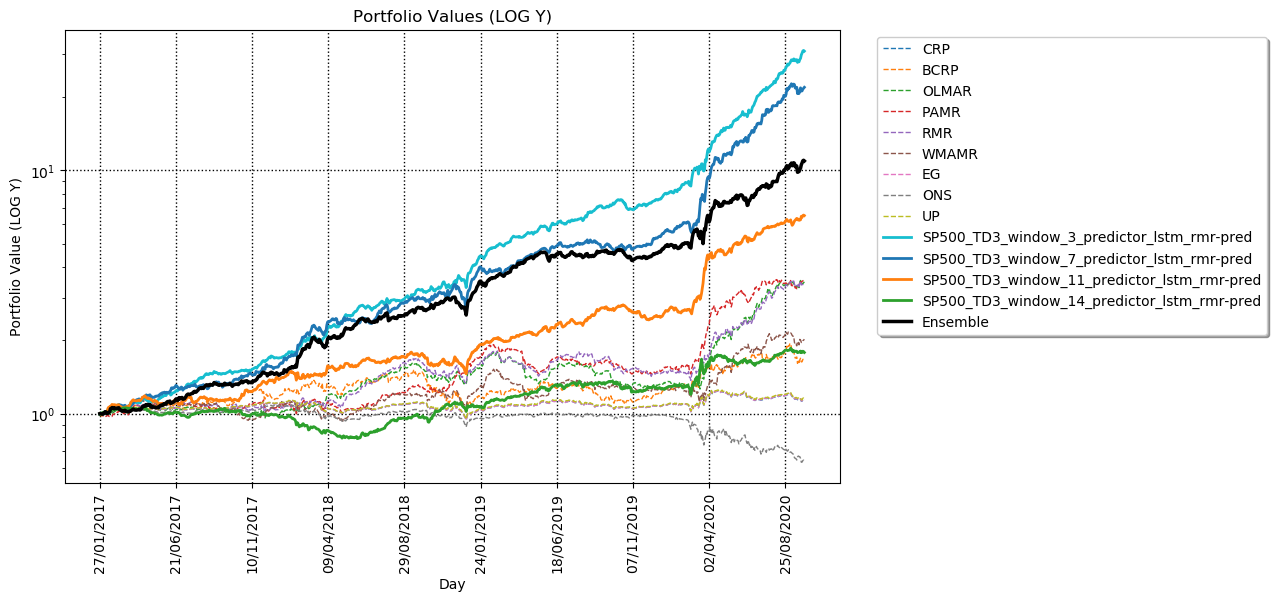

In [22]:
# Plot Together
log_y = True
df = pd.DataFrame()
df["Date"] = dates
df.set_index('Date', inplace=True)
plt.figure(figsize=(10, 6), dpi=100)
if log_y:
    plt.title('Portfolio Values (LOG Y)')
    plt.ylabel('Portfolio Value (LOG Y)')
else:
    plt.title('Portfolio Values')
    plt.ylabel('Portfolio Value')
plt.xlabel('Day')

# OLPS
for i in range(len(olps_model_names)):
    df[olps_model_names[i]] = olps_portfolio_values_list[i]
    plt.plot(df[olps_model_names[i]], label=olps_model_names[i], 
             linewidth=1, 
             linestyle='dashed')

# Our models
for m in model_dict:
    df[m['name']] = m['portfolio_values']
    plt.plot(df[m['name']], label=m['name'], 
             linewidth=2)
    
# Ensemble
plt.plot(ensemble_portfolio_values, label='Ensemble', 
             linewidth=2.5,
            color='black')    
    
if log_y:
    plt.yscale('log')
plt.xticks(np.arange(0, len(dates), 100))
plt.xticks(rotation=90)
plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1), shadow=True, ncol=1)
plt.grid(color='black', linestyle=':', linewidth=1)
plt.show()

In [23]:
ensemble_df = pd.DataFrame()
ensemble_df['selected_models'] = selected_models
ensemble_df['selected_sharpe'] = selected_sharpe
ensemble_df['Ensemble'] = ensemble_portfolio_values
ensemble_df["Date"] = dates
ensemble_df.set_index('Date', inplace=True)
ensemble_df['index'] = list(range(len(df)))

# Our models
for m in model_dict:
    ensemble_df[m['name']] = m['portfolio_values']

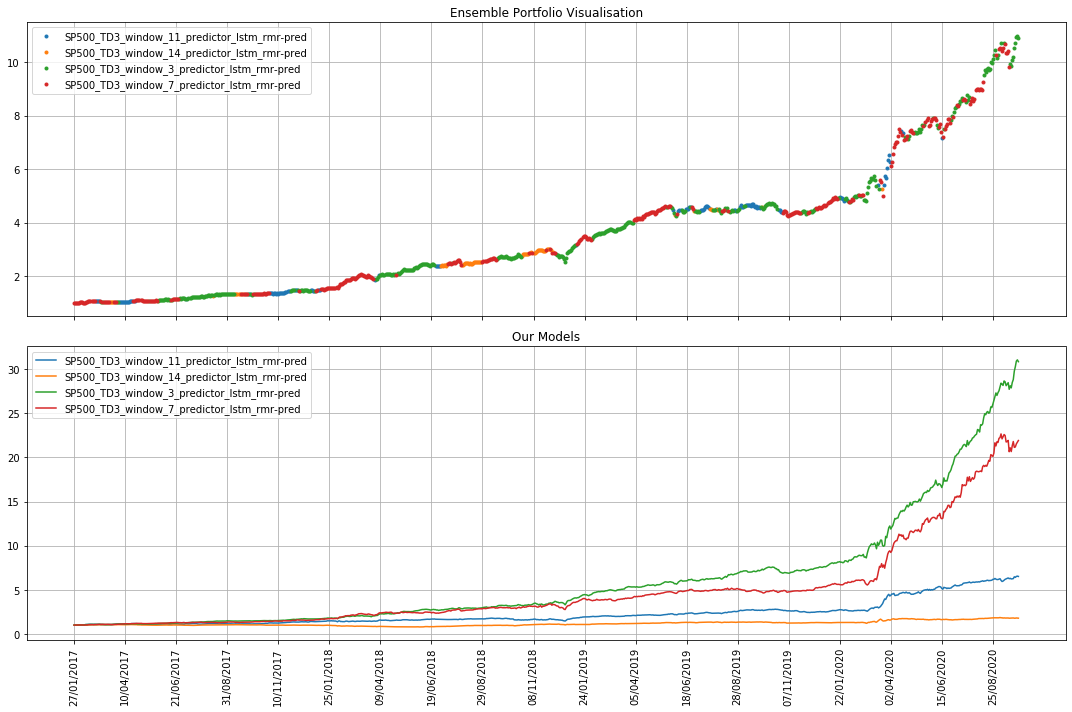

In [24]:
fig, axs = plt.subplots(2, sharex=True)
fig.set_figheight(10)
fig.set_figwidth(15)

axs[0].set_title('Ensemble Portfolio Visualisation')
groups = ensemble_df.groupby("selected_models")
for name, group in groups:
    axs[0].plot(group['index'], group['Ensemble'], marker=".", linestyle="", label=name)
axs[0].grid()
axs[0].legend()

# Main Picked Agents
axs[1].set_title('Our Models')
for name, group in groups:
    axs[1].plot(ensemble_df[name], label=name)
    
#for m in model_dict:
#    df[m['name']] = m['portfolio_values']
#    axs[1].plot(df[m['name']], label=m['name'], 
#             linewidth=2)
axs[1].grid()
axs[1].legend()

plt.xticks(np.arange(0, len(dates), 50))
plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=90)
plt.tight_layout()
plt.show()

----------------
## Rolling Analysis
1. Rolling Average Daily Yield (%) 	
2. Rolling Sharpe Ratio (%)
3. Rolling Sortino Ratio (%) 
4. Rolling Maximum Drawdown (%)

In [25]:
rolling_window = 100

portfolio_values_list = []
for m in model_dict:
    portfolio_values_list.append(m['portfolio_values'])

##### Rolling Average Daily Yield

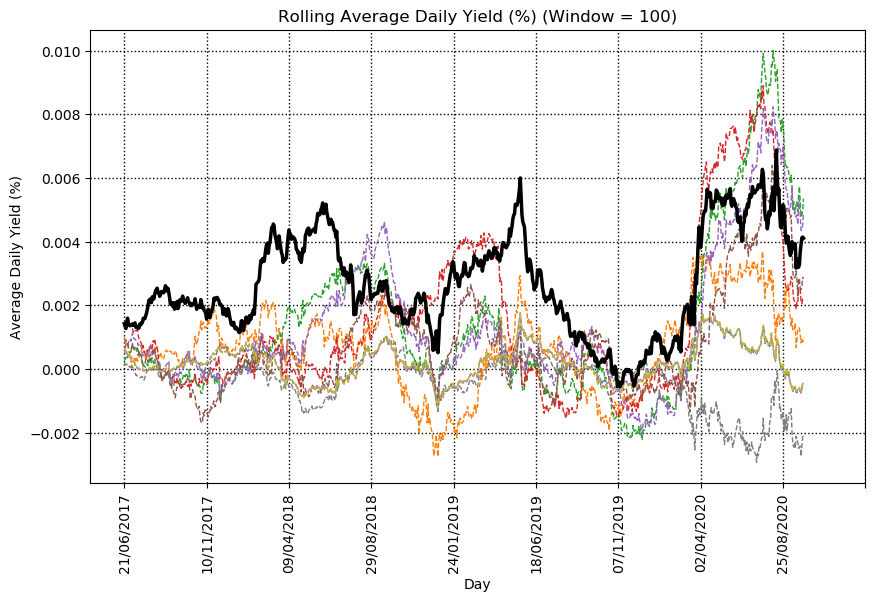

In [40]:
roll_ady_df = pd.DataFrame()
roll_ady_df["Date"] = dates
roll_ady_df.set_index('Date', inplace=True)
plt.figure(figsize=(10, 6), dpi=100)
plt.title('Rolling Average Daily Yield (%) (Window = {})'.format(rolling_window))
plt.ylabel('Average Daily Yield (%)')
plt.xlabel('Day')

# OLPS
for i in range(len(olps_model_names)):
    roll_ady_df['returns'] =  np.append(np.repeat(np.nan, 1), returns_from_cumulative(olps_portfolio_values_list[i]))
    roll_ady_df[olps_model_names[i]] = roll_ady_df['returns'].rolling(rolling_window).apply(np.mean, raw=True)
    plt.plot(roll_ady_df[olps_model_names[i]].iloc[rolling_window:], label=olps_model_names[i], 
             linewidth=1, 
             linestyle='dashed')

# Our models
for i in range(len(model_names)):
    roll_ady_df['returns'] =  np.append(np.repeat(np.nan, 1), returns_from_cumulative(portfolio_values_list[i]))
    roll_ady_df[model_names[i]] = roll_ady_df['returns'].rolling(rolling_window).apply(np.mean, raw=True)
#    plt.plot(roll_ady_df[model_names[i]].iloc[rolling_window:], label=model_names[i], 
#             linewidth=2)

# Ensemble
roll_ady_df['returns'] = np.append(np.repeat(np.nan, 1), returns_from_cumulative(ensemble_portfolio_values))
roll_ady_df['ensemble_model'] = roll_ady_df['returns'].rolling(rolling_window).apply(np.mean, raw=True)
plt.plot(roll_ady_df['ensemble_model'].iloc[rolling_window:], label='Ensemble model', 
         linewidth=2.5,
         color='black')

plt.xticks(np.arange(0, len(dates), rolling_window))
plt.xticks(rotation=90)
#plt.legend(loc='upper center', bbox_to_anchor=(1.15, 1), shadow=True, ncol=1)
plt.grid(color='black', linestyle=':', linewidth=1)
plt.show()

# Drop column
roll_ady_df.drop('returns', axis=1, inplace=True)

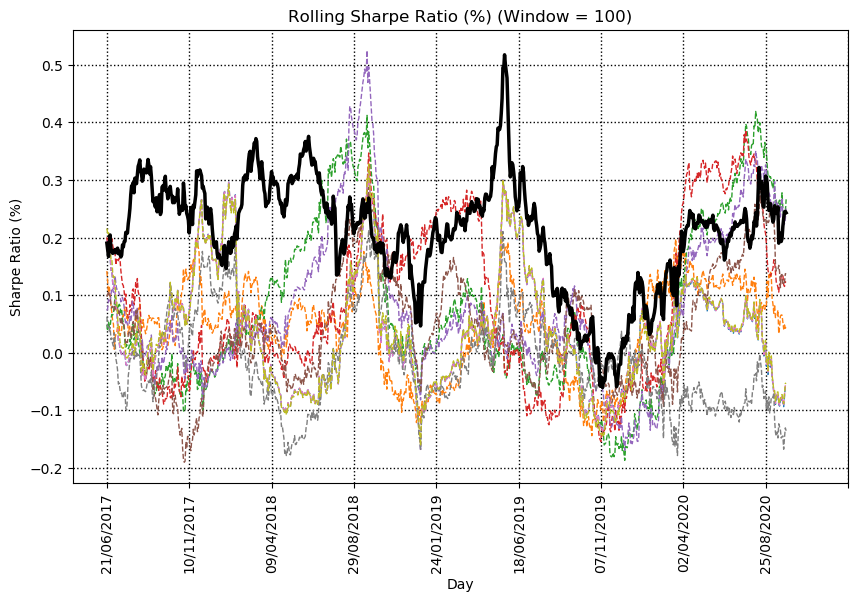

In [27]:
roll_sha_df = pd.DataFrame()
roll_sha_df["Date"] = dates
roll_sha_df.set_index('Date', inplace=True)
plt.figure(figsize=(10, 6), dpi=100)
plt.title('Rolling Sharpe Ratio (%) (Window = {})'.format(rolling_window))
plt.ylabel('Sharpe Ratio (%)')
plt.xlabel('Day')

# OLPS
for i in range(len(olps_model_names)):
    roll_sha_df['returns'] =  np.append(np.repeat(np.nan, 1), returns_from_cumulative(olps_portfolio_values_list[i]))
    roll_sha_df[olps_model_names[i]] = roll_sha_df['returns'].rolling(rolling_window).apply(sharpe, raw=True)
    plt.plot(roll_sha_df[olps_model_names[i]].iloc[rolling_window:], label=olps_model_names[i], 
             linewidth=1, 
             linestyle='dashed')

# Our models
for i in range(len(model_names)):
    roll_sha_df['returns'] =  np.append(np.repeat(np.nan, 1), returns_from_cumulative(portfolio_values_list[i]))
    roll_sha_df[model_names[i]] = roll_sha_df['returns'].rolling(rolling_window).apply(sharpe, raw=True)
#    plt.plot(roll_sha_df[model_names[i]].iloc[rolling_window:], label=model_names[i], 
#             linewidth=2)

# Ensemble
roll_sha_df['returns'] = np.append(np.repeat(np.nan, 1), returns_from_cumulative(ensemble_portfolio_values))
roll_sha_df['ensemble_model'] = roll_sha_df['returns'].rolling(rolling_window).apply(sharpe, raw=True)
plt.plot(roll_sha_df['ensemble_model'].iloc[rolling_window:], label='Ensemble model', 
         linewidth=2.5,
         color='black')

plt.xticks(np.arange(0, len(dates), rolling_window))
plt.xticks(rotation=90)
#plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1), shadow=True, ncol=1)
plt.grid(color='black', linestyle=':', linewidth=1)
plt.show()

# Drop column
roll_sha_df.drop('returns', axis=1, inplace=True)

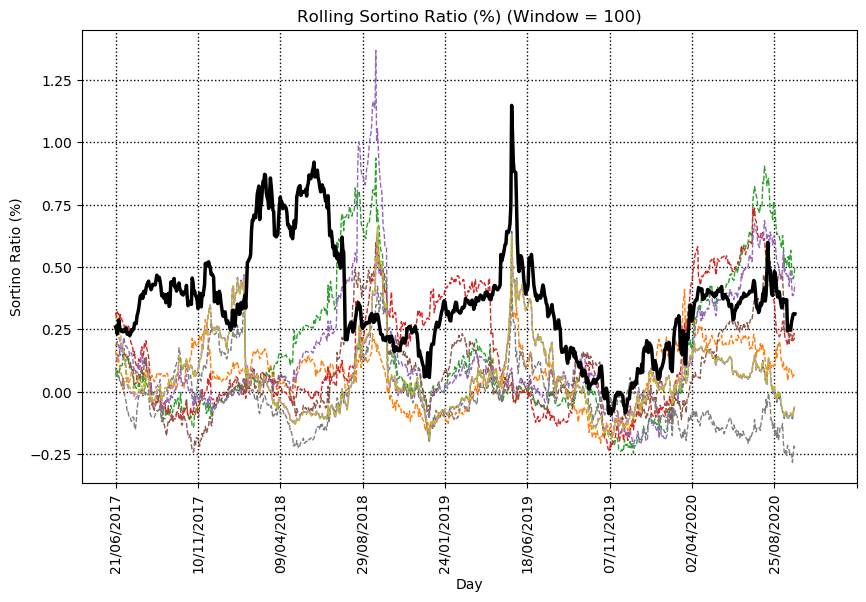

In [28]:
roll_sor_df = pd.DataFrame()
roll_sor_df["Date"] = dates
roll_sor_df.set_index('Date', inplace=True)
plt.figure(figsize=(10, 6), dpi=100)
plt.title('Rolling Sortino Ratio (%) (Window = {})'.format(rolling_window))
plt.ylabel('Sortino Ratio (%)')
plt.xlabel('Day')

# OLPS
for i in range(len(olps_model_names)):
    roll_sor_df['returns'] =  np.append(np.repeat(np.nan, 1), returns_from_cumulative(olps_portfolio_values_list[i]))
    roll_sor_df[olps_model_names[i]] = roll_sor_df['returns'].rolling(rolling_window).apply(sortino, raw=True)
    plt.plot(roll_sor_df[olps_model_names[i]].iloc[rolling_window:], label=olps_model_names[i], 
             linewidth=1, 
             linestyle='dashed')

# Our models
for i in range(len(model_names)):
    roll_sor_df['returns'] =  np.append(np.repeat(np.nan, 1), returns_from_cumulative(portfolio_values_list[i]))
    roll_sor_df[model_names[i]] = roll_sor_df['returns'].rolling(rolling_window).apply(sortino, raw=True)
#    plt.plot(roll_sor_df[model_names[i]].iloc[rolling_window:], label=model_names[i], 
#             linewidth=2)

# Ensemble
roll_sor_df['returns'] = np.append(np.repeat(np.nan, 1), returns_from_cumulative(ensemble_portfolio_values))
roll_sor_df['ensemble_model'] = roll_sor_df['returns'].rolling(rolling_window).apply(sortino, raw=True)
plt.plot(roll_sor_df['ensemble_model'].iloc[rolling_window:], label='Ensemble model', 
         linewidth=2.5,
         color='black')

plt.xticks(np.arange(0, len(dates), rolling_window))
plt.xticks(rotation=90)
#plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1), shadow=True, ncol=1)
plt.grid(color='black', linestyle=':', linewidth=1)
plt.show()

# Drop column
roll_sor_df.drop('returns', axis=1, inplace=True)

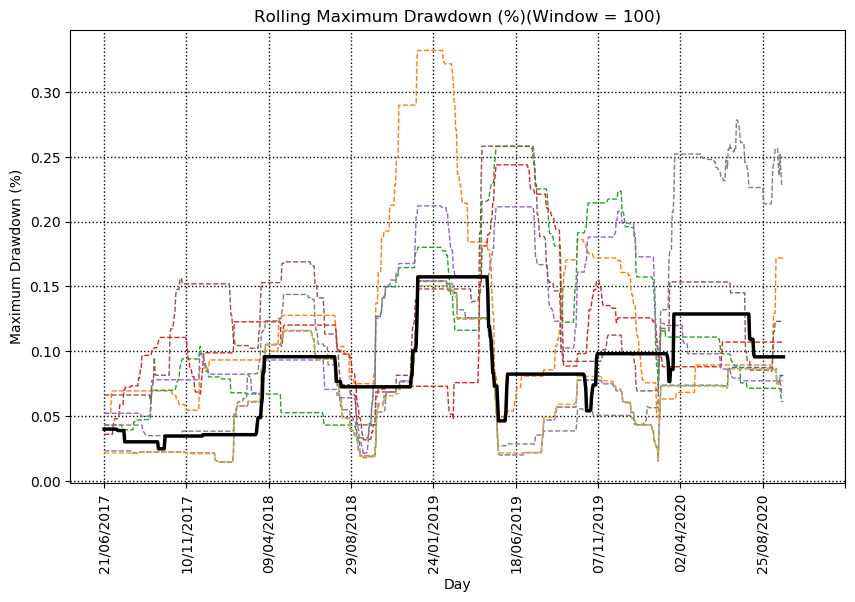

In [29]:
roll_mdd_df = pd.DataFrame()
roll_mdd_df["Date"] = dates
roll_mdd_df.set_index('Date', inplace=True)
plt.figure(figsize=(10, 6), dpi=100)
plt.title('Rolling Maximum Drawdown (%)(Window = {})'.format(rolling_window))
plt.ylabel('Maximum Drawdown (%)')
plt.xlabel('Day')

# OLPS
for i in range(len(olps_model_names)):
    roll_mdd_df['returns'] =  olps_portfolio_values_list[i]
    roll_mdd_df[olps_model_names[i]] = roll_mdd_df['returns'].rolling(rolling_window).apply(max_drawdown, raw=True)
    plt.plot(roll_mdd_df[olps_model_names[i]].iloc[rolling_window:], label=olps_model_names[i], 
             linewidth=1, 
             linestyle='dashed')

# Our models
for i in range(len(model_names)):
    roll_mdd_df['returns'] =  portfolio_values_list[i]
    roll_mdd_df[model_names[i]] = roll_mdd_df['returns'].rolling(rolling_window).apply(max_drawdown, raw=True)
#    plt.plot(roll_mdd_df[model_names[i]].iloc[rolling_window:], label=model_names[i], 
#             linewidth=2)

# Ensemble
roll_mdd_df['returns'] = ensemble_portfolio_values
roll_mdd_df['ensemble_model'] = roll_mdd_df['returns'].rolling(rolling_window).apply(max_drawdown, raw=True)
plt.plot(roll_mdd_df['ensemble_model'].iloc[rolling_window:], label='Ensemble model', 
         linewidth=2.5,
         color='black')

plt.xticks(np.arange(0, len(dates), rolling_window))
plt.xticks(rotation=90)
#plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1), shadow=True, ncol=1)
plt.grid(color='black', linestyle=':', linewidth=1)
plt.show()

# Drop column
roll_mdd_df.drop('returns', axis=1, inplace=True)

In [30]:
# Average Daily Yield (%) 	Sharpe Ratio (%) 	Sortino Ratio (%) 	Maximum Drawdown (%)
# Mean and Standard deviation
temp = roll_ady_df.mean(axis = 0, skipna = True)
ady = ((temp-temp.min())/(temp.max()-temp.min())).tolist()
ady.insert(0, "Average Daily Yield")

temp = roll_sha_df.mean(axis = 0, skipna = True)
sha = ((temp-temp.min())/(temp.max()-temp.min())).tolist()
sha.insert(0, "Sharpe Ratio")

temp = roll_sor_df.mean(axis = 0, skipna = True)
sor = ((temp-temp.min())/(temp.max()-temp.min())).tolist()
sor.insert(0, "Sortino Ratio")

temp = roll_mdd_df.mean(axis = 0, skipna = True)
mdd = (1 - (temp-temp.min())/(temp.max()-temp.min())).tolist()
mdd.insert(0, "Maximum Drawdown (inverted)")

_results_df = pd.DataFrame([ady, sha, sor, mdd], columns=["Evaluation Criteria"] + roll_ady_df.columns.tolist())

_results_df.set_index('Evaluation Criteria', inplace=True)
_results_df

,CRP,BCRP,OLMAR,PAMR,RMR,WMAMR,EG,ONS,UP,SP500_TD3_window_3_predictor_lstm_rmr-pred,SP500_TD3_window_7_predictor_lstm_rmr-pred,SP500_TD3_window_11_predictor_lstm_rmr-pred,SP500_TD3_window_14_predictor_lstm_rmr-pred,ensemble_model
Evaluation Criteria,,,,,,,,,,,,,,
Average Daily Yield,0.133106,0.264506,0.426425,0.456496,0.417306,0.292595,0.133704,0.000000,0.134995,1.0,0.930023,0.603892,0.258304,0.749568
Sharpe Ratio,0.161696,0.185227,0.280355,0.310147,0.293602,0.180898,0.162172,0.000000,0.165679,1.0,0.729739,0.510613,0.202982,0.685690
Sortino Ratio,0.139477,0.153393,0.301767,0.302882,0.302076,0.176837,0.139391,0.000000,0.142379,1.0,0.757734,0.509173,0.177132,0.690003
Maximum Drawdown (inverted),0.919114,0.054865,0.148349,0.249137,0.139967,0.000000,0.918842,0.429913,0.923958,1.0,0.655036,0.680605,0.508299,0.622237


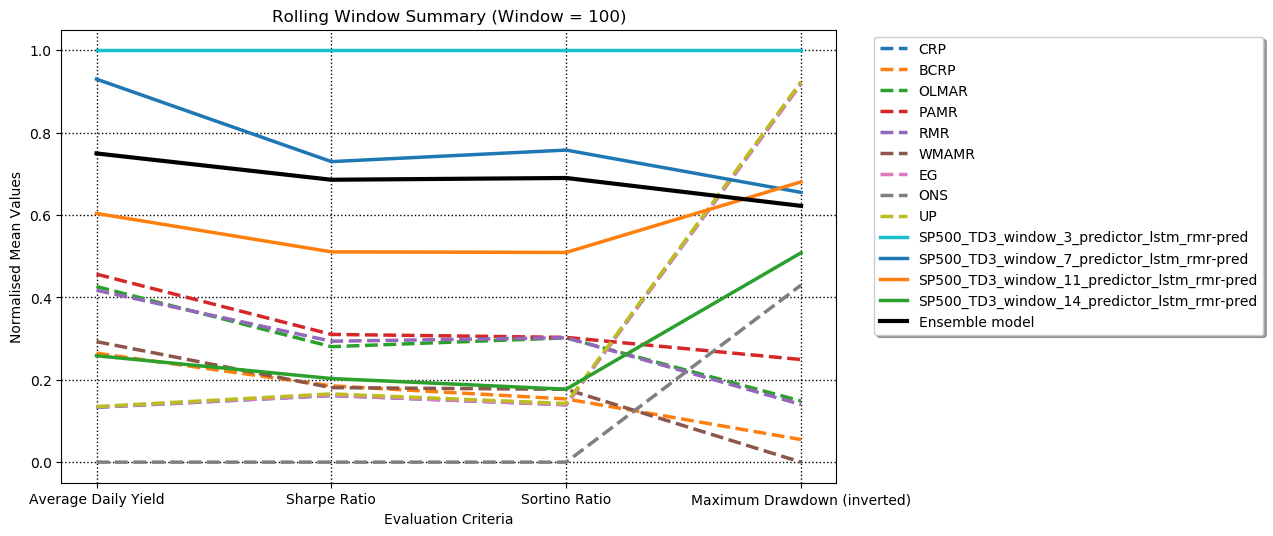

In [31]:
plt.figure(figsize=(10, 6), dpi=100)
plt.title('Rolling Window Summary (Window = {})'.format(rolling_window))
plt.ylabel('Normalised Mean Values')
plt.xlabel('Evaluation Criteria')

# OLPS
for i in range(len(olps_model_names)):
    plt.plot(_results_df[olps_model_names[i]], label=olps_model_names[i], 
             linewidth=2.5, 
             linestyle='dashed')

# Our models
for i in range(len(model_names)):
    plt.plot(_results_df[model_names[i]], label=model_names[i], 
             linewidth=2.5)
    
# Ensemble
plt.plot(_results_df['ensemble_model'], label='Ensemble model', 
             linewidth=3,
        color='black')

plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1), shadow=True, ncol=1)
plt.grid(color='black', linestyle=':', linewidth=1)
plt.show()

##### Statistical summary via T-test

In [32]:
from scipy.stats import ttest_ind_from_stats

In [33]:
n = len(roll_ady_df)
our_model = 'ensemble_model'
benchmarks = olps_model_names + model_names
print("{} vs... t-tests".format(our_model))

ensemble_model vs... t-tests


In [34]:
# Average Daily Yield (%)
mean = roll_ady_df.mean(axis = 0, skipna = True).tolist()
mean.insert(0, "mean")
std = roll_ady_df.std(axis = 0, skipna = True).tolist()
std.insert(0, "std")
_results_df = pd.DataFrame([mean, std], columns=["Value"] + roll_ady_df.columns.tolist())
_results_df.set_index('Value', inplace=True)

ady_tstat_list = ['ADY_tstat']
ady_pvalue_list = ['ADY_pvalue']

for olps_model in benchmarks:
    tstat, pvalue = ttest_ind_from_stats(_results_df[our_model]['mean'], _results_df[our_model]['std'], n, 
                                         _results_df[olps_model]['mean'], _results_df[olps_model]['std'], n)
    ady_tstat_list.append('%.4g' % tstat)
    ady_pvalue_list.append('%.4g' % pvalue)
    
    print("{} | tstat = {} | pvalue = {}".format(olps_model, tstat, pvalue))
    if(tstat > 0):
        print("Win")
    else:
        print("Lose")
    print("-----------------------------------------------------------------")

CRP | tstat = 45.07333159779651 | pvalue = 5.0933779442257474e-300
Win
-----------------------------------------------------------------
BCRP | tstat = 28.55726072687664 | pvalue = 6.470227567504094e-149
Win
-----------------------------------------------------------------
OLMAR | tstat = 13.180033746026073 | pvalue = 5.559424978026147e-38
Win
-----------------------------------------------------------------
PAMR | tstat = 12.247809056176683 | pvalue = 3.215418354021949e-33
Win
-----------------------------------------------------------------
RMR | tstat = 15.382531792613042 | pvalue = 2.4404550896142907e-50
Win
-----------------------------------------------------------------
WMAMR | tstat = 24.905828803109944 | pvalue = 2.5585883971513086e-118
Win
-----------------------------------------------------------------
EG | tstat = 45.002304018372044 | pvalue = 2.3443206225929213e-299
Win
-----------------------------------------------------------------
ONS | tstat = 51.48017783393549 | pva

In [35]:
# Sharpe Ratio (%)
mean = roll_sha_df.mean(axis = 0, skipna = True).tolist()
mean.insert(0, "mean")
std = roll_sha_df.std(axis = 0, skipna = True).tolist()
std.insert(0, "std")
_results_df = pd.DataFrame([mean, std], columns=["Value"] + roll_sha_df.columns.tolist())
_results_df.set_index('Value', inplace=True)

sha_tstat_list = ['SHA_tstat']
sha_pvalue_list = ['SHA_pvalue']

for olps_model in benchmarks:
    tstat, pvalue = ttest_ind_from_stats(_results_df[our_model]['mean'], _results_df[our_model]['std'], n, 
                                         _results_df[olps_model]['mean'], _results_df[olps_model]['std'], n)
    sha_tstat_list.append('%.4g' % tstat)
    sha_pvalue_list.append('%.4g' % pvalue)
    
    print("{} | tstat = {} | pvalue = {}".format(olps_model, tstat, pvalue))
    if(tstat > 0):
        print("Win")
    else:
        print("Lose")
    print("-----------------------------------------------------------------")

CRP | tstat = 37.83721805679986 | pvalue = 1.5703909841207896e-232
Win
-----------------------------------------------------------------
BCRP | tstat = 40.31116887677613 | pvalue = 1.5305518321922673e-255
Win
-----------------------------------------------------------------
OLMAR | tstat = 22.930742540142624 | pvalue = 1.2631929894516842e-102
Win
-----------------------------------------------------------------
PAMR | tstat = 22.12507046865418 | pvalue = 1.990223581334805e-96
Win
-----------------------------------------------------------------
RMR | tstat = 23.8123603985232 | pvalue = 1.515588091154426e-109
Win
-----------------------------------------------------------------
WMAMR | tstat = 36.91184453498706 | pvalue = 5.756354258216706e-224
Win
-----------------------------------------------------------------
EG | tstat = 37.8180137667014 | pvalue = 2.36607188939698e-232
Win
-----------------------------------------------------------------
ONS | tstat = 53.78589283121004 | pvalue = 

In [36]:
# Sortino Ratio (%)
mean = roll_sor_df.mean(axis = 0, skipna = True).tolist()
mean.insert(0, "mean")
std = roll_sor_df.std(axis = 0, skipna = True).tolist()
std.insert(0, "std")
_results_df = pd.DataFrame([mean, std], columns=["Value"] + roll_sor_df.columns.tolist())
_results_df.set_index('Value', inplace=True)

sor_tstat_list = ['SOR_tstat']
sor_pvalue_list = ['SOR_pvalue']

for olps_model in benchmarks:
    tstat, pvalue = ttest_ind_from_stats(_results_df[our_model]['mean'], _results_df[our_model]['std'], n, 
                                         _results_df[olps_model]['mean'], _results_df[olps_model]['std'], n)
    sor_tstat_list.append('%.4g' % tstat)
    sor_pvalue_list.append('%.4g' % pvalue)
    
    print("{} | tstat = {} | pvalue = {}".format(olps_model, tstat, pvalue))
    if(tstat > 0):
        print("Win")
    else:
        print("Lose")
    print("-----------------------------------------------------------------")

CRP | tstat = 35.269384632569775 | pvalue = 7.542618546090515e-209
Win
-----------------------------------------------------------------
BCRP | tstat = 36.58327553238368 | pvalue = 6.21637764715914e-221
Win
-----------------------------------------------------------------
OLMAR | tstat = 18.611260456485365 | pvalue = 5.281280109036225e-71
Win
-----------------------------------------------------------------
PAMR | tstat = 20.52439324880511 | pvalue = 1.6664252658231054e-84
Win
-----------------------------------------------------------------
RMR | tstat = 19.38949295594324 | pvalue = 2.1627189182094743e-76
Win
-----------------------------------------------------------------
WMAMR | tstat = 31.569715973573533 | pvalue = 2.3497222033276913e-175
Win
-----------------------------------------------------------------
EG | tstat = 35.313514010830225 | pvalue = 2.971476526376789e-209
Win
-----------------------------------------------------------------
ONS | tstat = 46.005185260240644 | pvalu

In [37]:
# Maximum Drawdown (%)
mean = roll_mdd_df.mean(axis = 0, skipna = True).tolist()
mean.insert(0, "mean")
std = roll_mdd_df.std(axis = 0, skipna = True).tolist()
std.insert(0, "std")
_results_df = pd.DataFrame([mean, std], columns=["Value"] + roll_mdd_df.columns.tolist())
_results_df.set_index('Value', inplace=True)

mdd_tstat_list = ['MDD_tstat']
mdd_pvalue_list = ['MDD_pvalue']

for olps_model in benchmarks:
    tstat, pvalue = ttest_ind_from_stats(_results_df[our_model]['mean'], _results_df[our_model]['std'], n, 
                                         _results_df[olps_model]['mean'], _results_df[olps_model]['std'], n)
    mdd_tstat_list.append('%.4g' % tstat)
    mdd_pvalue_list.append('%.4g' % pvalue)
    
    print("{} | tstat = {} | pvalue = {}".format(olps_model, tstat, pvalue))
    if(tstat < 0):
        print("Win")
    else:
        print("Lose")
    print("-----------------------------------------------------------------")

CRP | tstat = 11.20562694658464 | pvalue = 3.0371918594636627e-28
Lose
-----------------------------------------------------------------
BCRP | tstat = -14.201335025490236 | pvalue = 1.5949588855064315e-43
Win
-----------------------------------------------------------------
OLMAR | tstat = -12.76830211088704 | pvalue = 7.654698757380685e-36
Win
-----------------------------------------------------------------
PAMR | tstat = -12.584621480981186 | pvalue = 6.607591187177782e-35
Win
-----------------------------------------------------------------
RMR | tstat = -15.079826974190437 | pvalue = 1.4937386338306094e-48
Win
-----------------------------------------------------------------
WMAMR | tstat = -19.584782213987225 | pvalue = 9.122940254253649e-78
Win
-----------------------------------------------------------------
EG | tstat = 11.191775092979446 | pvalue = 3.5160824385128978e-28
Lose
-----------------------------------------------------------------
ONS | tstat = -4.6800843059906345 

In [38]:
stat_df = pd.DataFrame([ady_tstat_list, ady_pvalue_list, 
                       sha_tstat_list, sha_pvalue_list, 
                       sor_tstat_list, sor_pvalue_list, 
                       mdd_tstat_list, mdd_pvalue_list], columns=['value']+benchmarks)
stat_df.set_index('value', inplace=True)
stat_df

,CRP,BCRP,OLMAR,PAMR,RMR,WMAMR,EG,ONS,UP,SP500_TD3_window_3_predictor_lstm_rmr-pred,SP500_TD3_window_7_predictor_lstm_rmr-pred,SP500_TD3_window_11_predictor_lstm_rmr-pred,SP500_TD3_window_14_predictor_lstm_rmr-pred
value,,,,,,,,,,,,,
ADY_tstat,45.07,28.56,13.18,12.25,15.38,24.91,45,51.48,44.87,-12.14,-7.185,7.052,28.76
ADY_pvalue,5.093e-300,6.47e-149,5.559e-38,3.215e-33,2.44e-50,2.559e-118,2.344e-299,0,3.806e-298,1.07e-32,9.671e-13,2.49e-12,1.057e-150
SHA_tstat,37.84,40.31,22.93,22.13,23.81,36.91,37.82,53.79,37.33,-24.33,-3.065,12.23,28.87
SHA_pvalue,1.57e-232,1.531e-255,1.263e-102,1.99e-96,1.516e-109,5.756e-224,2.366e-232,0,8.129e-228,1.229e-113,0.002207,3.842e-33,1.385e-151
SOR_tstat,35.27,36.58,18.61,20.52,19.39,31.57,35.31,46.01,34.98,-17.92,-3.435,10.23,29.34
SOR_pvalue,7.543e-209,6.216e-221,5.281e-71,1.666e-84,2.163e-76,2.35e-175,2.971e-209,1.032e-308,3.291e-206,2.585e-66,0.0006054,6.418e-24,1.007e-155
MDD_tstat,11.21,-14.2,-12.77,-12.58,-15.08,-19.58,11.19,-4.68,11.46,17.01,1.193,2.17,-4.184
MDD_pvalue,3.037e-28,1.595e-43,7.655e-36,6.608e-35,1.494e-48,9.123e-78,3.516e-28,3.076e-06,2.054e-29,2.218e-60,0.2332,0.03016,2.994e-05


In [39]:
stat_df.T

value,ADY_tstat,ADY_pvalue,SHA_tstat,SHA_pvalue,SOR_tstat,SOR_pvalue,MDD_tstat,MDD_pvalue
CRP,45.07,5.093e-300,37.84,1.57e-232,35.27,7.543e-209,11.21,3.037e-28
BCRP,28.56,6.47e-149,40.31,1.531e-255,36.58,6.216e-221,-14.2,1.595e-43
OLMAR,13.18,5.559e-38,22.93,1.263e-102,18.61,5.281e-71,-12.77,7.655e-36
PAMR,12.25,3.215e-33,22.13,1.99e-96,20.52,1.666e-84,-12.58,6.608e-35
RMR,15.38,2.44e-50,23.81,1.516e-109,19.39,2.163e-76,-15.08,1.494e-48
WMAMR,24.91,2.559e-118,36.91,5.756e-224,31.57,2.35e-175,-19.58,9.123e-78
EG,45,2.344e-299,37.82,2.366e-232,35.31,2.971e-209,11.19,3.516e-28
ONS,51.48,0,53.79,0,46.01,1.032e-308,-4.68,3.076e-06
UP,44.87,3.806e-298,37.33,8.129e-228,34.98,3.291e-206,11.46,2.054e-29
SP500_TD3_window_3_predictor_lstm_rmr-pred,-12.14,1.07e-32,-24.33,1.229e-113,-17.92,2.585e-66,17.01,2.218e-60
